# Clustering gerarchico

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

#Prepocessing per clustering: scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #ultimo per otuliers: mantiene outliers considerando il range interquartile

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer

Il clustering gerarchico verrà fatto sugli stessi attributi del k-means per poterli confrontare e vedere quele clusetr è il milgiore per il nostor datset

- attributi: **valence, dominance, concreteness, aoa e semsize**

In [2]:
df = pd.read_csv("normative.csv", skipinitialspace=True)
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'aoa', 'semsize']    # s = 0.25   
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'familiarity', 'aoa', 'semsize']    #originale con s = 0.23
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'aoa'] 
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness'] 
#attr_cluster = ['valence', 'dominance', 'concreteness'] 
attr_cluster = [ 'valence', 'dominance', 'concreteness', 'aoa', 'semsize']    
X = df[attr_cluster]

X_cat = df.drop(columns = ['word','length','arousal','valence', 'dominance','concreteness', 'imageability', 'aoa','familiarity', 'semsize', 'gender', 'frequency_log'  ])
X_num = df[attr_cluster]

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) 

X.head()

,valence,dominance,concreteness,aoa,semsize
0,2.864,4.333,5.455,6.760,4.652
1,5.781,4.667,5.906,5.177,5.121
2,5.250,5.235,3.286,5.543,2.667
3,3.767,4.419,3.367,6.233,4.679
4,3.880,4.800,3.292,6.407,5.083


## Dendogrammi

Funzione per plottare i **dendogrammi**

In [4]:
## Copiato da scipy
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
methods = ['single', 'complete', 'average', 'ward']

In [8]:
#we compute the heght of the cut suggested by the default color_threshold
defaults_color_thresholds = []
for method in methods:
    Z = linkage(X_minmax, method)
    defaults_color_thresholds.append(0.7*max(Z[:,2]))

### Dendogrammi dei 4 metodi (single, complete, avarege e Ward)

In [6]:
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(X_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    hierarchical_models.append(model)
    
    axs[i].set_title('Cluster gerarchico con algoritmo ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage')
    axs[i].set_xlabel('Cluster Size')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(defaults_color_thresholds[i], ls='--', color='r')

#plt.suptitle(('A comparison among the different linkages and dendrograms with Default Color Threshold'),fontsize=18, fontweight='bold')
plt.show()

KeyboardInterrupt: 

I migliori sembrerebbero **Complete** e **Avarage**

### Best Cut 
Calcoliamo il miglior taglio (**best cut**)

In [10]:
def get_best_cut(linkage, step, norm_dataframe):
    store_n_clusters = []
    store_distances = []

    n_clusters = 0
    i = 0

    while n_clusters != 1:
        distance_threshold = i*step
        model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_dataframe)
        i = i + 1

        n_clusters = model.n_clusters_
        store_distances.append(distance_threshold)
        store_n_clusters.append(n_clusters)

    df = pd.DataFrame()

    df['distance_thresholds'] = store_distances
    df['n_clusters'] = store_n_clusters
    
    df_n_clusters_groups = df.groupby('n_clusters').size()
    
    n_for_opt_cut = df_n_clusters_groups.agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance_thresholds.min()
    
    print('Performed analysis for ' + linkage + '-linkage: reached n_clusters = 1 in ' + str(i) + ' steps')
    #print('OPT: Dist = ' + str(distance) + ', n_clusters = ' + str(n_for_opt_cut))     
    
    return n_for_opt_cut, distance

In [11]:
steps = [0.001, 0.01, 0.01, 0.1]

opt_n_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], X_minmax)
    opt_n_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['n_clusters_for_best_cut'] = opt_n_clusters
hierarchical_distances['height'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

Performed analysis for single-linkage: reached n_clusters = 1 in 282 steps
Performed analysis for complete-linkage: reached n_clusters = 1 in 160 steps
Performed analysis for average-linkage: reached n_clusters = 1 in 73 steps
Performed analysis for ward-linkage: reached n_clusters = 1 in 242 steps


,n_clusters_for_best_cut,height
method,,
single,2,0.23
complete,2,1.48
average,3,0.61
ward,3,10.80


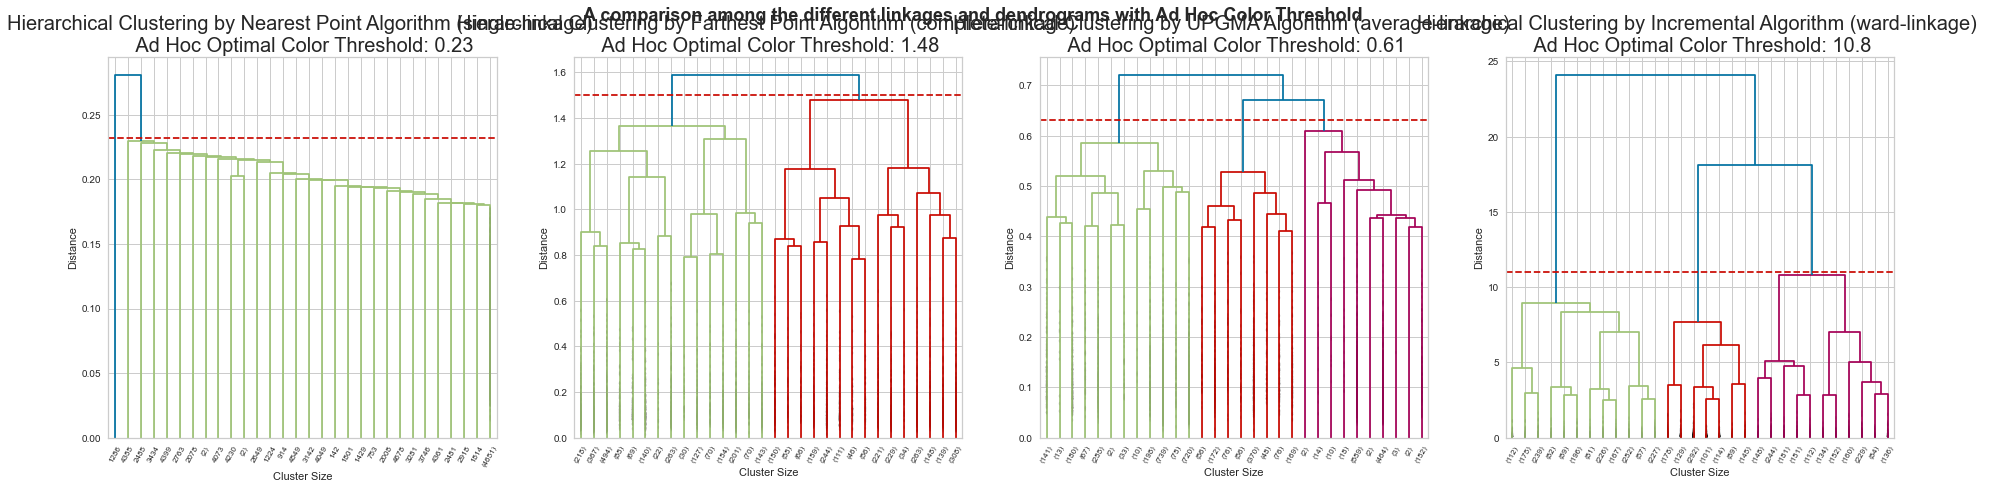

In [13]:
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].height
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(X_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
    hierarchical_models.append(model)
    
    axs[i].set_title('Hierarchical Clustering by ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage) \n Ad Hoc Optimal Color Threshold: ' + str(color_threshold), fontsize = 20)
    axs[i].set_xlabel('Cluster Size')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(color_threshold + steps[i]*2, ls='--', color='r')

plt.suptitle(('A comparison among the different linkages and dendrograms with Ad Hoc Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

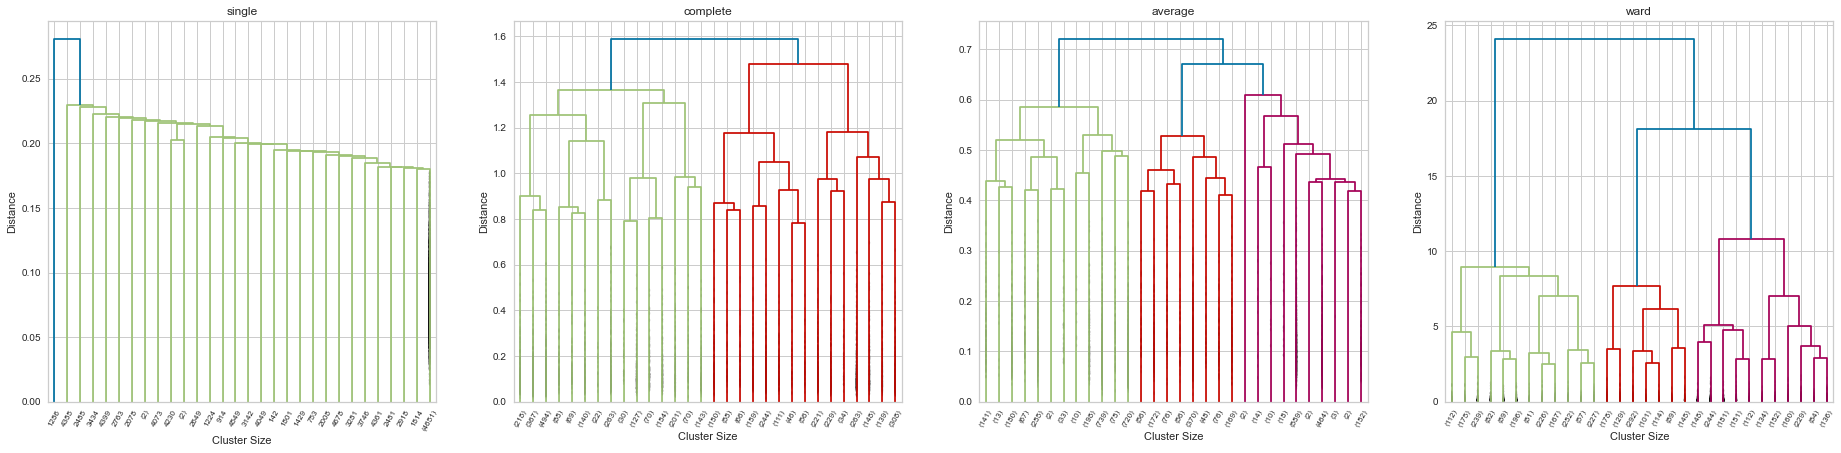

In [12]:
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].height
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(X_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
    hierarchical_models.append(model)
    
    axs[i].set_title(methods[i])
    axs[i].set_xlabel('Cluster Size')
    axs[i].set_ylabel('Distance')
    #axs[i].axhline(color_threshold + steps[i]*2, ls='--', color='r')

#plt.suptitle(('Comparazione dei 4 cluster gerarchici utilizzando una soglia adeguata'),fontsize=18, fontweight='bold')
plt.show()

In [15]:
X_clusters = X
for i in range(len(methods)):
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    labels = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage=methods[i]).fit_predict(X_minmax)
    X_clusters[methods[i]] = labels

X_clusters[['single', 'complete', 'average', 'ward']]

<ipython-input-15-f8f6faadd59e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clusters[methods[i]] = labels
<ipython-input-15-f8f6faadd59e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clusters[methods[i]] = labels
<ipython-input-15-f8f6faadd59e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

,single,complete,average,ward
0,0,1,2,2
1,0,1,1,1
2,0,1,0,0
3,0,0,2,2
4,0,0,2,2
...,...,...,...,...
4677,0,1,1,1
4678,0,1,1,1
4679,0,1,0,0
4680,0,1,1,1


In [16]:
X_clusters

,valence,dominance,concreteness,aoa,semsize,single,complete,average,ward
0,2.864,4.333,5.455,6.760,4.652,0,1,2,2
1,5.781,4.667,5.906,5.177,5.121,0,1,1,1
2,5.250,5.235,3.286,5.543,2.667,0,1,0,0
3,3.767,4.419,3.367,6.233,4.679,0,0,2,2
4,3.880,4.800,3.292,6.407,5.083,0,0,2,2
...,...,...,...,...,...,...,...,...,...
4677,5.000,5.333,6.286,6.036,5.464,0,1,1,1
4678,4.182,4.567,2.688,2.636,1.758,0,1,1,1
4679,6.818,6.121,4.438,5.364,2.636,0,1,0,0
4680,6.235,5.485,6.118,2.324,4.844,0,1,1,1


In [17]:
X.head()

,valence,dominance,concreteness,aoa,semsize,single,complete,average,ward
0,2.864,4.333,5.455,6.760,4.652,0,1,2,2
1,5.781,4.667,5.906,5.177,5.121,0,1,1,1
2,5.250,5.235,3.286,5.543,2.667,0,1,0,0
3,3.767,4.419,3.367,6.233,4.679,0,0,2,2
4,3.880,4.800,3.292,6.407,5.083,0,0,2,2


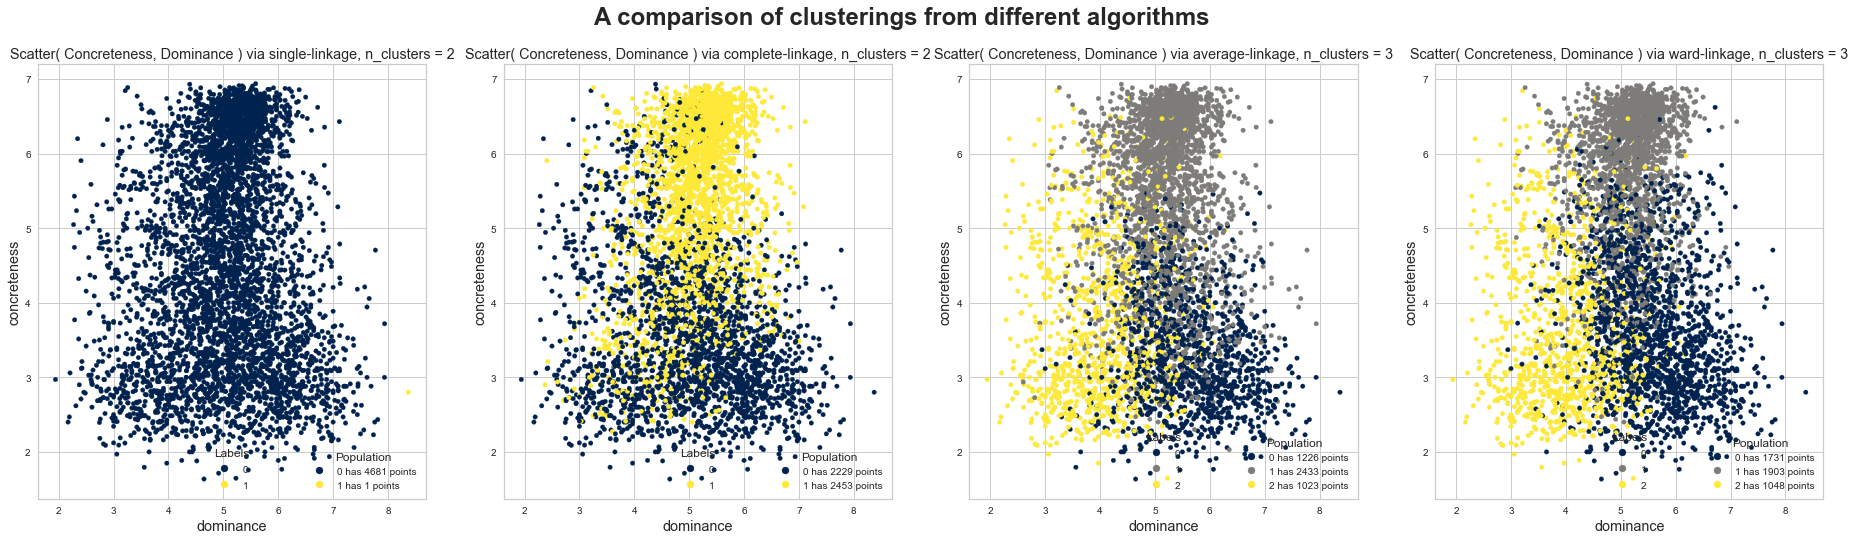

In [18]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 'dominance', 'concreteness'

for i in range(len(methods)):
    labels = X_clusters[methods[i]]
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    scatter = axs[i].scatter(X[a], X[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title('Scatter( Concreteness, Dominance ) via ' + methods[i] + '-linkage, n_clusters = ' + str(opt_n_clusters), fontdict={'fontsize': 'large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    dbs_population = np.unique(labels, return_counts=True)

    legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                        loc="lower center", title="Labels")
    
    axs[i].add_artist(legend1)

    # produce a legend 
    secondlegend = []
    classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
    legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

plt.suptitle(('A comparison of clusterings from different algorithms'),
             fontsize=24, fontweight='bold')
    
plt.show()


Scatter solo metodo avarage: il migliore

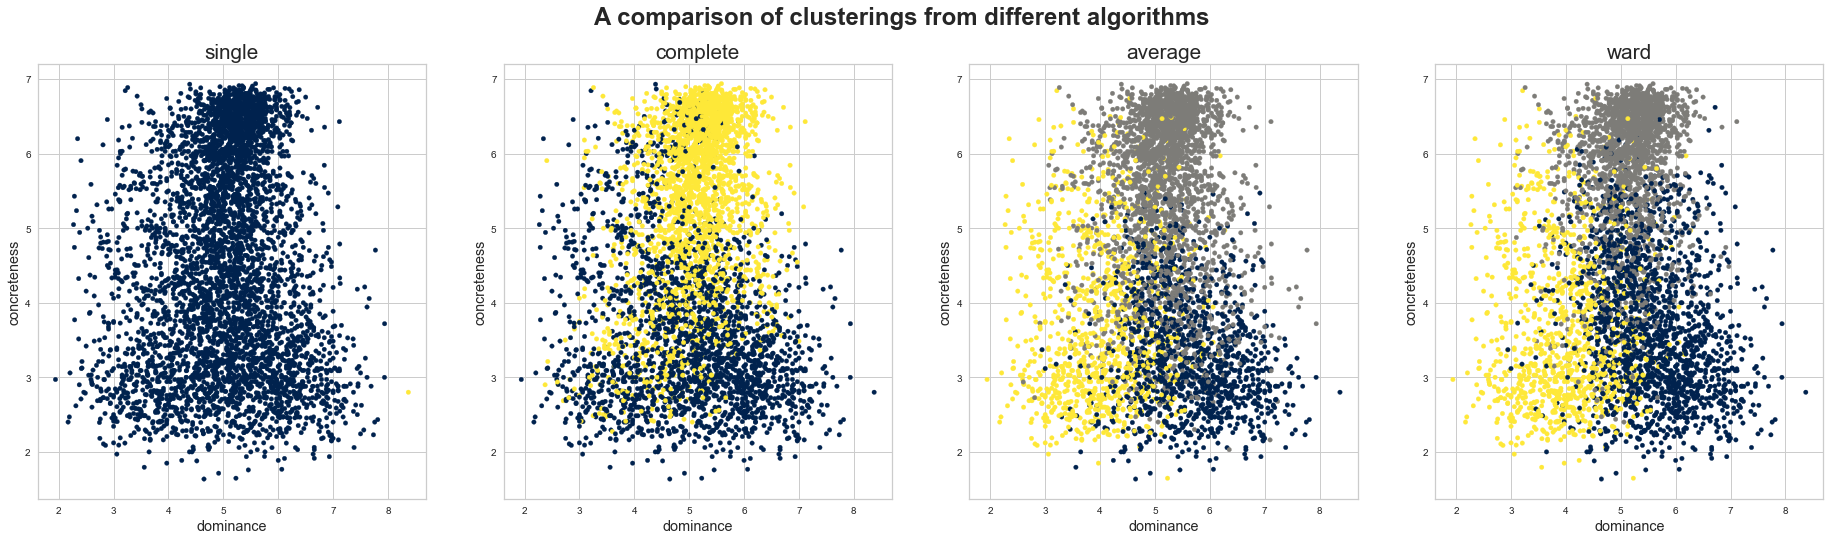

In [19]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
a, b = 'dominance', 'concreteness'

for i in range(len(methods)):
    labels = X_clusters[methods[i]]
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    scatter = axs[i].scatter(X[a], X[b], c=labels, s=20, cmap='cividis')
    axs[i].set_title(methods[i], fontdict={'fontsize': 'xx-large'})
    axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
    axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    
    # produce a legend with the unique colors from the scatter
    #dbs_population = np.unique(labels, return_counts=True)

    #legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection. loc="lower center", title="Labels")
    
   # axs[i].add_artist(legend1)

    # produce a legend 
    #secondlegend = []
    #classes = np.unique(labels).shape[0]

    for j in range(classes):
        secondlegend.append("{} ha {} punti".format(j, dbs_population[1][j]))
    handles = scatter.legend_elements()[0]
    labels_2 = secondlegend
legend2 = axs[i].legend(handles, labels_2, loc="upper right", title="Population")

#plt.suptitle(('A comparison of clusterings from different algorithms'), fontsize=24, fontweight='bold')
    
plt.show()


In [31]:
X_clusters

,valence,dominance,concreteness,aoa,semsize,single,complete,average,ward
0,2.864,4.333,5.455,6.760,4.652,0,1,2,2
1,5.781,4.667,5.906,5.177,5.121,0,1,1,1
2,5.250,5.235,3.286,5.543,2.667,0,1,0,0
3,3.767,4.419,3.367,6.233,4.679,0,0,2,2
4,3.880,4.800,3.292,6.407,5.083,0,0,2,2
...,...,...,...,...,...,...,...,...,...
4677,5.000,5.333,6.286,6.036,5.464,0,1,1,1
4678,4.182,4.567,2.688,2.636,1.758,0,1,1,1
4679,6.818,6.121,4.438,5.364,2.636,0,1,0,0
4680,6.235,5.485,6.118,2.324,4.844,0,1,1,1


In [20]:
methods = ['complete', 'average', 'ward']

### Valutazione


In [21]:
int_metrics_H=pd.DataFrame() # we create a dataframe to contain the results of the evaluation
sil=[]

for method in methods:

    if method != 'single':
        #sep.append(davies_bouldin_score(X_minmax, X_clusters[method]))
        sil.append(silhouette_score(X_minmax, X_clusters[method]))
        #cal_har.append(calinski_harabasz_score(X_minmax, X_clusters[method]))

int_metrics_H['Linkage'] = methods
#int_metrics_H['Davies_Bouldini'] = sep
int_metrics_H['Silhouette'] = sil
#int_metrics_H['Calinski_Harabasz'] = cal_har
int_metrics_H.set_index(['Linkage'], inplace=True)
int_metrics_H

,Silhouette
Linkage,
complete,0.188526
average,0.252491
ward,0.269300


In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet


In [23]:
cophenetic_coefficients = []

for method in methods:
    Z = linkage(X_minmax, method)
    cophenetic_coefficients = np.append(cophenetic_coefficients, np.corrcoef(pdist(X_minmax), cophenet(Z))[0][1])

In [24]:
hierarchical_eval = pd.DataFrame()
hierarchical_eval['method'] = methods
hierarchical_eval['cophenetic_corr'] = cophenetic_coefficients
hierarchical_eval.set_index(['method'], inplace=True)
hierarchical_eval


,cophenetic_corr
method,
complete,0.499487
average,0.570137
ward,0.553537


In [25]:
df_cat = pd.read_csv("normative.csv", skipinitialspace=True)

df_cat['length_cat'] = pd.qcut(df_cat['length'], 4, labels=["corte", "medie", "lunghe", "molto lunghe"])
df_cat['familiarity_cat'] = pd.qcut(df_cat['familiarity'], 4, labels=["molto poco", "poco", "familiare", "molto familiare"])
df_cat['frequency_cat'] = pd.qcut(df_cat['frequency_log'], 4, labels=["poco freq", "medio freq", "freq", "molto freq"])
df_cat['arousal_cat'] = pd.qcut(df_cat['arousal'], 4, labels=["molto calmante", "calmante", "eccitante", "molto eccitante"])

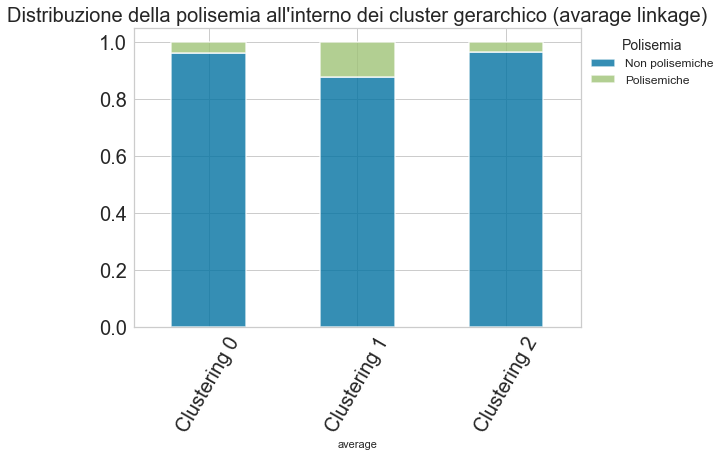

In [26]:
bar_pl = df['polysemy'].groupby(X['average']).value_counts(normalize = True).unstack(1)
bar_pl.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Distribuzione della polisemia all'interno dei cluster gerarchico (avarage linkage)", fontsize = 20)
plt.legend(["Non polisemiche", "Polisemiche"],bbox_to_anchor =(1,1), title = 'Polisemia', title_fontsize = 14, fontsize = 12)





plt.show()

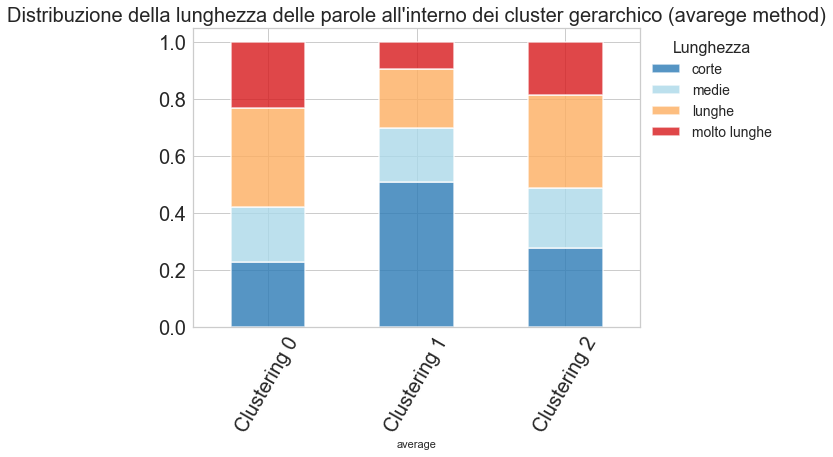

In [27]:
bar_pl1 = df_cat['length_cat'].groupby(X['average']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#2c7bb6', '#abd9e9', '#fdae61', '#d7191c'])
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Distribuzione della lunghezza delle parole all'interno dei cluster gerarchico (avarege method)", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Lunghezza', title_fontsize = 16, fontsize = 14)




plt.show()

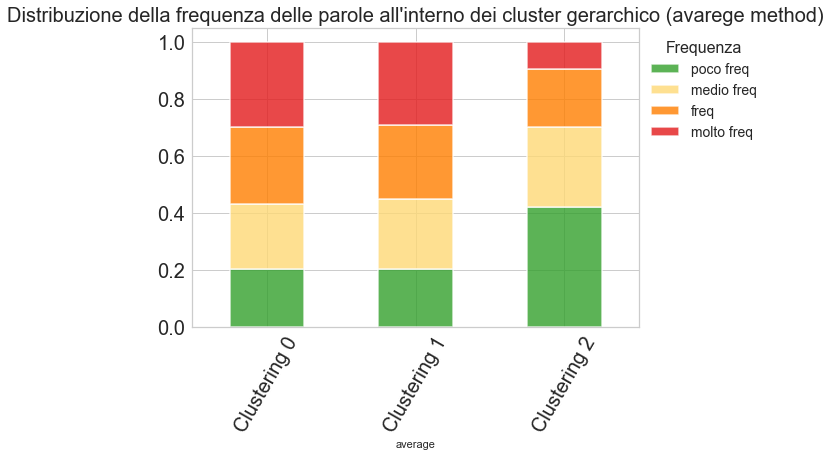

In [28]:
bar_pl1 = df_cat['frequency_cat'].groupby(X['average']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#33a02c', '#fed976','#ff7f00','#e31a1c'])
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Distribuzione della frequenza delle parole all'interno dei cluster gerarchico (avarege method)", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Frequenza', title_fontsize = 16, fontsize = 14)




plt.show()

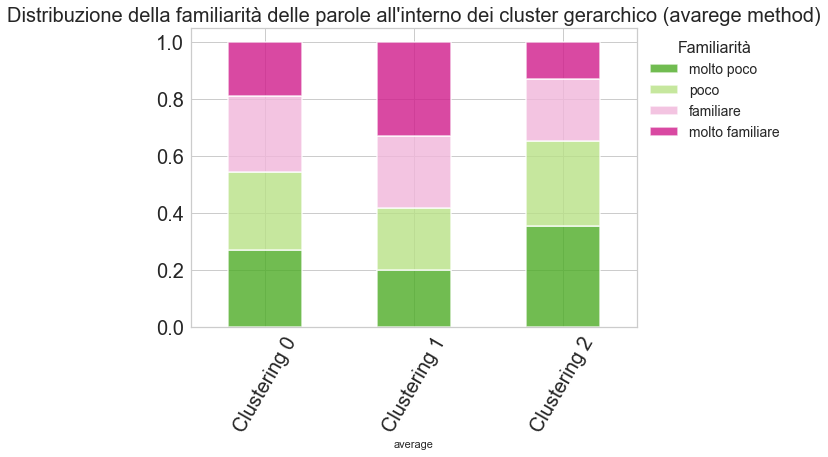

In [29]:
bar_pl1 = df_cat['familiarity_cat'].groupby(X['average']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#4dac26', '#b8e186', '#f1b6da', '#d01c8b'])
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Distribuzione della familiarità delle parole all'interno dei cluster gerarchico (avarege method)", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Familiarità', title_fontsize = 16, fontsize = 14)




plt.show()

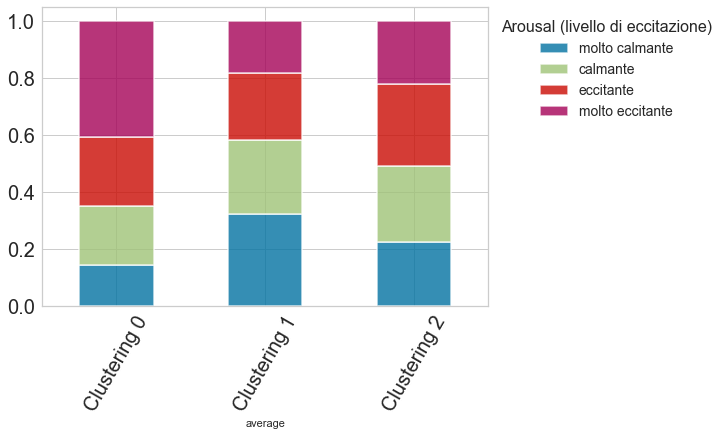

In [30]:

bar_pl1 = df_cat['arousal_cat'].groupby(X['average']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor =(1,1), title = 'Arousal (livello di eccitazione)', title_fontsize = 16, fontsize = 14)



plt.show()

# In dettaglio

Creare una matrice di prossimità con parametri:
- valori scalati
- metric = metrica 'euclidiana'


In [43]:
data_dist = pdist(X_minmax, metric='euclidean')

Inizializiamo un algoritmo gerarchico linkage, parametri:
- passiamo la matrice
- method = il metodo che vogliamo passare come single (gerachia composta da 2), complete, avarege


## Visualizzazione dei dendogrammi utilizzando i vari metodi di cluster gerarchico

Plottiamo il dendogramma con parametri:
- risultato dell'algortimo gerarchico
- truncate_mode = 'lastp' è necessrio usare il metodo truncate per selezionare ua soglia e non visualizzare tutto il dendogramma

## Min o single:
- strane forme
- diverse grandezze e compattezze
- atene di conenssioni
- fallisce qaundo c'è molto rumore

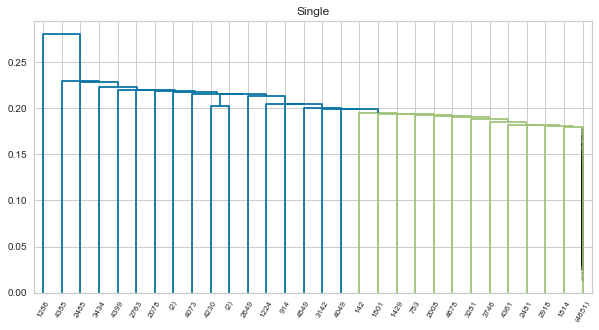

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Single")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(X_minmax, method='single'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

### Ward:
- no rumore
- biased verso cluster circolari
- simile al k-mean

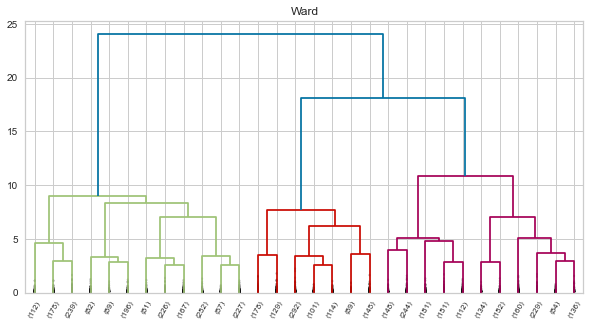

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Ward")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(X_minmax, method='ward'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

### Max o complete:
- susciettibile a rumore e outliers (ma meno del min) 
- rompe grandi cluster sopratutto se di diversa grandezza 
- simile: cluster di forma circolare più o meno della stessa grandezza

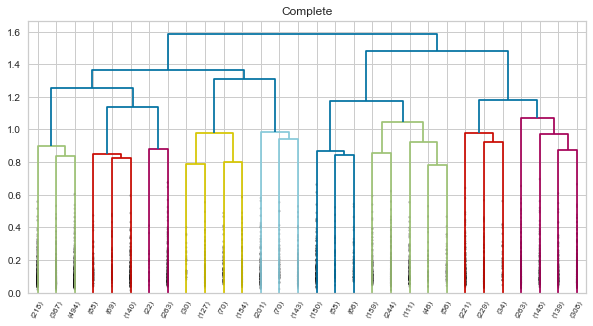

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Complete")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(X_minmax, method='complete'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

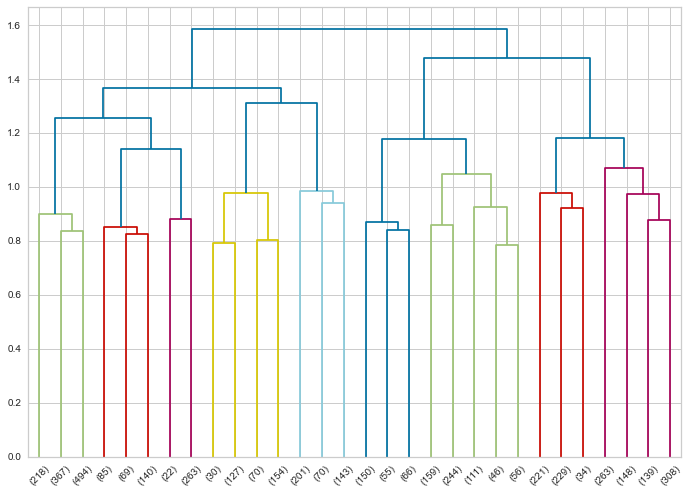

In [47]:
data_link = linkage(data_dist, method='complete')
res = dendrogram(data_link, truncate_mode='lastp') # color_threshold = 0.5 per selezionare il livello

### Group avarage:
- simile a max

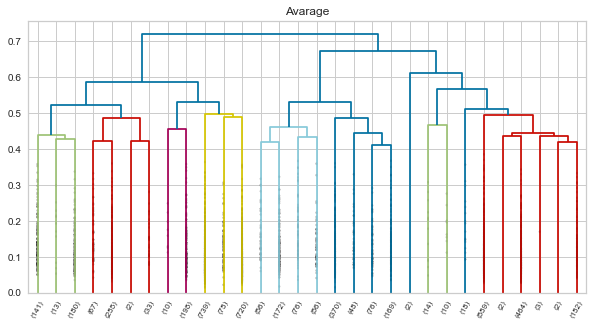

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Avarage")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(X_minmax, method='average'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

Da questo dendogramma possiamo vedere che:
- sono presenti due  differneti clusters
- quando si ha un singolo valore significa che il valore corrisponde al singolo valore nel dataset, mentre un valore come (n) significa che corrisponde a n valori 
- è utile per verificare la gerarchia globale nel dataset


In generale è buona norma  osservare differenti dendogrammi per ogni metodo  (signle, complete, avarage) e sceglierne uno. Ci permette di capire il numero di clusters

### Accedere ai labels

AgglomerativeClustering() è un metodo per accedere ai labels del cluster, alla distribuzione ecc., utile per mergiare i valori categorici e continui:
- n_clusters =  scegliere il numero di clsuters, con signle method abbiamo 2 clusters
- affinity = da inserire poiché non stiamo lavorando con una matrice di prossimità
- linkage = selezioanre il metodo signle, complete, avarage ecc.

Fit serve per runnare il metodo:
- passare distace matrix generica 



In [49]:
hier = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
hier.fit(X_minmax)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=2)

In [50]:
#si possono ottenere le etichette
hier.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

E' possibile modificare il valore di affinity nel metodo AgglomerativeClustering con <b>'precomputed'</b> per poter utilizzare una matrice precomputata

In [51]:
hier = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='single')
hier.fit( dist ) #passo una matrice di distanza calcolata precedentemente

NameError: name 'dist' is not defined